In [151]:
# ==========================================
# 📘 Predict durationMs (User engagement time)
# ==========================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import StackingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [152]:
# ============================================
# 🧩 Load and prepare dataset
# ============================================
input_path = "cleaned_advanced_events.csv"  # update if needed
df = pd.read_csv(input_path, low_memory=False)

print(f"✅ Loaded: {df.shape}")

✅ Loaded: (109566, 50)


In [153]:
print(df.isnull().sum())

eventType                    0
region                       0
city                         0
timezone                     0
clickX                       0
clickY                       0
scrollPercent                0
durationMs                   0
domLoadTime                  0
fullLoadTime                 0
ttfb                         0
downlink                     0
effectiveType                0
rtt                          0
errorMessage                 0
errorSource                  0
errorLine                    0
errorColumn                  0
clickX_was_missing           0
clickY_was_missing           0
scrollPercent_was_missing    0
screenWidth                  0
screenHeight                 0
aspectRatio                  0
deviceType                   0
url_length                   0
url_depth                    0
is_course_page               0
is_dashboard                 0
browser_simplified           0
lang_main                    0
region_group                 0
scroll_r

In [154]:
# -------------------------
# Define target & features
# -------------------------
target_col = "durationMs"

# drop target and any direct transformations of it
leak_cols = [target_col, "durationMs_log", "durationMs_log1p"]
X = df.drop(columns=[c for c in leak_cols if c in df.columns], errors="ignore")
y = df[target_col]

In [155]:
# -------------------------
# Train-test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [156]:
# -------------------------
# Scaling numeric features (optional)
# -------------------------
num_cols = X_train.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [157]:
# -------------------------
# Train models
# -------------------------
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=0.001, random_state=42),
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42),
    # "Huber": HuberRegressor(epsilon=1.35), # get minus R2 score
    "ExtraTrees": ExtraTreesRegressor(
        n_estimators=200, max_depth=None, random_state=42, n_jobs=-1
    ),
    # "AdaBoost": AdaBoostRegressor(
    #     n_estimators=200, learning_rate=0.05, random_state=42
    # ), # get minus R2 score
    # "SVR": SVR(C=10, kernel="rbf", gamma="scale"), # get minus R2 score
    # "KernelRidge": KernelRidge(alpha=1.0, kernel="rbf"), # not enough memory 50GB
    "MLP": MLPRegressor(hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300, random_state=42),
    "RandomForest": RandomForestRegressor(
        n_estimators=150, max_depth=20, random_state=42, n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42
    ),
    "XGBoost": XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=-1, random_state=42, n_jobs=-1
    ),
}

estimators = [
    ("rf", models["RandomForest"]),
    ("xgb", models["XGBoost"]),
    ("lgbm", models["LightGBM"]),
    ("ridge", models["Ridge"]),
]
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=GradientBoostingRegressor(
        n_estimators=150, learning_rate=0.05, max_depth=3, random_state=42
    ),
    n_jobs=-1
)
models["StackedEnsemble"] = stack

results = []
for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = root_mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append((name, mae, rmse, r2))
    print(f"{name} => MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")


Training Linear ...
Linear => MAE: 462363.00, RMSE: 1098368.24, R2: 0.1605

Training Ridge ...
Ridge => MAE: 462295.86, RMSE: 1098363.74, R2: 0.1605

Training Lasso ...
Lasso => MAE: 462304.61, RMSE: 1098452.51, R2: 0.1604

Training ElasticNet ...
ElasticNet => MAE: 461410.11, RMSE: 1098453.38, R2: 0.1604

Training ExtraTrees ...
ExtraTrees => MAE: 219627.19, RMSE: 869073.40, R2: 0.4744

Training MLP ...
MLP => MAE: 300734.15, RMSE: 1012475.02, R2: 0.2867

Training RandomForest ...
RandomForest => MAE: 221462.96, RMSE: 865826.65, R2: 0.4783

Training GradientBoosting ...
GradientBoosting => MAE: 297092.95, RMSE: 935327.26, R2: 0.3912

Training XGBoost ...
XGBoost => MAE: 270136.06, RMSE: 893747.10, R2: 0.4441

Training LightGBM ...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46

In [158]:
# -------------------------
# Model comparison
# -------------------------
results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R2"]).sort_values("R2", ascending=False)
print("\n🏁 Model Performance Ranking:")
print(results_df)


🏁 Model Performance Ranking:
               Model            MAE          RMSE        R2
10   StackedEnsemble  224364.525066  8.627676e+05  0.482011
6       RandomForest  221462.956774  8.658266e+05  0.478331
4         ExtraTrees  219627.191772  8.690734e+05  0.474411
9           LightGBM  243767.652569  8.748356e+05  0.467419
8            XGBoost  270136.057545  8.937471e+05  0.444144
7   GradientBoosting  297092.951722  9.353273e+05  0.391220
5                MLP  300734.148732  1.012475e+06  0.286652
1              Ridge  462295.862040  1.098364e+06  0.160491
0             Linear  462363.001198  1.098368e+06  0.160484
2              Lasso  462304.605932  1.098453e+06  0.160355
3         ElasticNet  461410.110418  1.098453e+06  0.160354


In [159]:
# -------------------------
# Feature Importance (LightGBM)
# -------------------------
best_model_name = results_df.sort_values("R2", ascending=False)["Model"].iloc[0]
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name}")

if hasattr(best_model, "feature_importances_"):
    importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    top_features = importances.sort_values(ascending=False).head(20)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_features.values, y=top_features.index)
    plt.title(f"Top 20 Features - {best_model_name}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()


Best model: StackedEnsemble


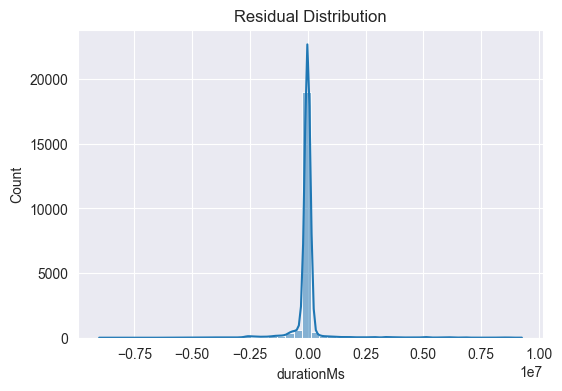

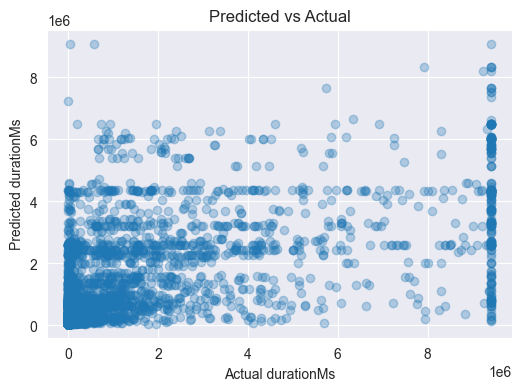

In [160]:
# -------------------------
# Residual analysis
# -------------------------
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residual Distribution")
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual durationMs")
plt.ylabel("Predicted durationMs")
plt.title("Predicted vs Actual")
plt.show()

In [161]:
# -------------------------
# Save best model predictions
# -------------------------
output_df = X_test.copy()
output_df["actual_durationMs"] = y_test
output_df["predicted_durationMs"] = y_pred
output_df.to_csv("model_results_durationMs.csv", index=False)
print("\n✅ Saved predictions → model_results_durationMs.csv")


✅ Saved predictions → model_results_durationMs.csv
